In [40]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [41]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [42]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [43]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [44]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [45]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [46]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [47]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [48]:
#Create measurement & station DF
measurement_df = pd.read_sql(session.query(Measurement).limit(5).statement, engine)

station_df = pd.read_sql(session.query(Station).limit(5).statement, engine)



In [49]:
measurement_df

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [50]:
station_df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Exploratory Precipitation Analysis

In [55]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Find the most recent date in the data set.
mostrecent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
mostrecent

'2017-08-23'

In [56]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.datetime(2017, 8, 23)


# Calculate the date one year from the last date in data set.
last_date = dt.datetime(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_date).all()


# Define a SQL query to retrieve precipitation data for a given date range
query = "SELECT date, prcp FROM measurement WHERE date >= '2016-08-23' AND date <= '2017-08-23'"

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.read_sql(query, engine)
precipitation = precipitation.set_index('date')


# Sort the dataframe by date
precipitation=precipitation.sort_values(by='date')
precipitation=precipitation.groupby('date').max()
precipitation 



,prcp
date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.56


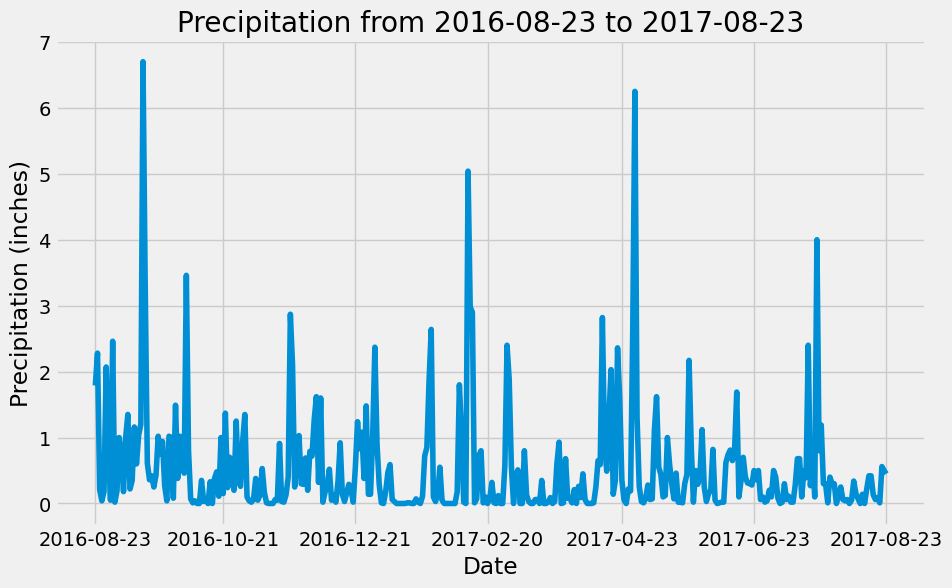

In [60]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(precipitation.index, precipitation['prcp'])
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation from 2016-08-23 to 2017-08-23')

interval = mdates.MonthLocator(interval=2)
plt.gca().xaxis.set_major_locator(interval)

plt.show()

In [58]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,prcp
count,366.000000
mean,0.520765
std,0.830728
min,0.000000
25%,0.040000
50%,0.250000
75%,0.672500
max,6.700000


# Exploratory Station Analysis

In [63]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station).distinct(Station.station).count()
station_count

9

In [64]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations_count = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()).all()

stations_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [67]:
#most active station 
most_active = stations_count[0][0]
most_active

'USC00519281'

In [66]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
max_temp = session.query(func.max(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').\
order_by(func.max(Measurement.tobs).desc()).all()
print(f'Max Temp ' + str(max_temp[0][0]))

min_temp = session.query(func.min(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').\
order_by (func.min(Measurement.tobs).desc()).all()
print (f'Min Temp ' + str(min_temp[0][0]))

avg_temp = session.query(func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').\
order_by(func.avg(Measurement.tobs).desc()).all()
print("Avg Temp "+ str(round(avg_temp[0][0],3)))

Max Temp 85.0
Min Temp 54.0
Avg Temp 71.664


In [72]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_ob = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= last_date).all()
df = pd.DataFrame(temp_ob,columns = ['tobs'])
print(df)



     tobs
0    77.0
1    80.0
2    80.0
3    75.0
4    73.0
..    ...
346  77.0
347  77.0
348  76.0
349  76.0
350  79.0

[351 rows x 1 columns]


Text(0.5, 0, 'Temperature')

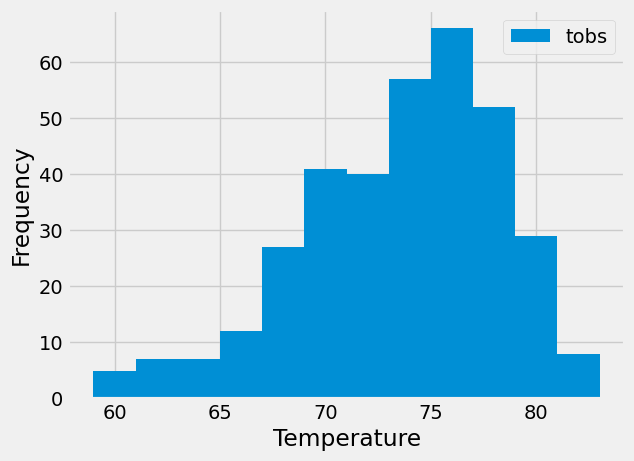

In [85]:
# execute the query and load the data into a pandas DataFrame

ax=df.plot.hist(bins=12)
ax.set_ylabel("Frequency")
ax.set_xlabel("Temperature")

# Close session

In [86]:
# Close Session
session.close()